In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [7]:
np.array([20000.0999833434]) * np.array([923823.034930])

array([1.84765531e+10])

In [10]:
from numpy.lib.function_base import gradient
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [25]:
class Encoder_test(keras.Model):

    def __init__(self, **kwargs):
        super(Encoder_test, self).__init__(**kwargs)

        # self.input_layer = keras.layers.Input(shape=(INPUT_SIZE))

        # self.f = keras.layers.Flatten()
        # self.l1 = keras.layers.Dense(364, activation="relu")
        # self.l2 = keras.layers.Dense(224, activation="relu")
        # self.l3 = keras.layers.Dense(124, activation="relu")
        # self.l4 = keras.layers.Dense(64, activation="relu")
        # self.l5 = keras.layers.Dense(24)
                
        self.conv_layer_one = keras.layers.Conv2D(24, 3, padding="valid", activation="relu") # 26 x 26
        self.conv_layer_two = keras.layers.Conv2D(64, 3, padding="valid", activation="relu") # 24 X 24
        self.pool_one = keras.layers.MaxPool2D(2, 2) # 12 x 12 X 64
        
        


    def __call__(self, inputs):

        # inputs = self.input_layer(inputs)
        # inputs = self.f(inputs)
        # inputs = self.l1(inputs)
        # inputs = self.l2(inputs)
        # inputs = self.l3(inputs)
        # inputs = self.l4(inputs)
        # inputs = self.l5(inputs)


        inputs = self.conv_layer_one(inputs)
        inputs = self.conv_layer_two(inputs)
        inputs = self.pool_one(inputs)

        flatten = keras.layers.Flatten()(inputs)
        fcn = keras.layers.Dense(64, activation="relu")(flatten)

        mean = keras.layers.Dense(LATENT_DIM)(fcn)
        mu_ = keras.layers.Dense(LATENT_DIM)(fcn)

        # mean = keras.layers.Dense(LATENT_DIM)(inputs)
        # mu_ = keras.layers.Dense(LATENT_DIM)(inputs)

        # enc_model = keras.models.Model( 
        #     inputs=[inputs], 
        #     outputs=[mean, mu_]
        # )
        
        return (mean, mu_)

class Decoder_test(keras.Model):

    def __init__(self, **kwargs):
        super(Decoder_test, self).__init__(**kwargs)

        self.input_layer = keras.layers.Input(shape=(LATENT_DIM) )
        # self.dense_layer = keras.layers.Dense(7 * 7 * 128)
        # self.reshape_layer = keras.layers.Reshape((7, 7, 128))

        # self.l_1 = keras.layers.Dense(24, activation="relu")
        # self.l_2 = keras.layers.Dense(64, activation="relu")
        # self.l_3 = keras.layers.Dense(124, activation="relu")
        # self.l_4 = keras.layers.Dense(224, activation="relu")
        # self.l_5 = keras.layers.Dense(364, activation="relu")
        # self.l_6 = keras.layers.Dense(28*28, activation="sigmoid")

        self.l_1_c = keras.layers.Dense(12*12, activation="relu")
        self.l_2_c = keras.layers.Reshape((12, 12, 1))
        self.l_3_c = keras.layers.Conv2DTranspose(64, 3, padding="valid", activation="relu")
        self.l_4_c = keras.layers.Conv2DTranspose(24, 3, strides=2,padding="same", activation="relu")
        self.l_5_c = keras.layers.Conv2DTranspose(1, 3, padding="same", activation="sigmoid")
        self.r = keras.layers.Reshape((28, 28))

        # write the sequential model in __call__()
    def __call__(self, inputs):
        
        dec_model = keras.models.Sequential([
            self.input_layer,
            # self.l_1,
            self.l_1_c,
            self.l_2_c,
            self.l_3_c,
            self.l_4_c,
            self.l_5_c,
            self.r
        ])

        return dec_model(inputs)


class Sampling(keras.layers.Layer):
    
    '''
    Reparamaterization Trick
    '''

    def __init__(self, **kwargs):
        super(Sampling, self).__init__(**kwargs)

    def __call__(self, inputs):

        '''
        Args:
            inputs - A tuple containing (mean, variance)
            output - A vector of shape LATENT_DIM
        '''

        mean, log_var = inputs
        sample = tf.random.normal([LATENT_DIM]) * tf.exp(log_var / 2) + mean

        return sample

class VAE_test(keras.Model):
    # Implement Holding the latent Vector

    def __init__(self, **kwargs):
        super(VAE_test, self).__init__(**kwargs)

        self.encoder = Encoder_test()
        self.decoder = Decoder_test()
    
    
    def __call__(self, inputs):
        '''
        Args:
            -input : inputs , shape = (batch, INPUT_SIZE , INPUT_SIZE)

            -output : (reconstruction, mean, log_var)
                reconstruction : shape = (batch, INPUT_SIZE, INPUT_SIZE)
                mean           : shape = (LATENT_DIM, 1)
                log_var        : shape = (LATENT_DIM, 1)
    
        '''

        inputs = inputs

        mean, log_var = self.encoder(inputs) #shape : INPUT_SIZE

        latent_vector = Sampling()((mean, log_var))

        reconstruction = self.decoder(latent_vector)

        # vae_model = keras.models.Model(inputs=[inputs], outputs=[reconstruction])

        return reconstruction, mean, log_var

In [52]:
def lr_scheduler(epoch, lr):
    if epoch == 20:
        lr = epoch / 10
    if epoch == 30:
        lr = epoch / 10
    
    return lr 

In [169]:

from numpy.lib.function_base import gradient
import tensorflow as tf
from tensorflow import keras
import numpy as np

from utils import LATENT_DIM
from utils import NO_EPOCHS
from utils import BATCH_SIZE
from utils import LEARNING_RATE

from models.model_def import VAE
from models.model_def import Encoder
from models.model_def import Decoder

keras_loss = tf.keras.losses.SparseCategoricalCrossentropy()


# Refactor Network_loss into class Network_loss
def Network_loss(mean, log_var, alpha=1, beta=1):

    def loss(y_true, y_pred):
        y_true = tf.reshape(y_true, (-1, 28, 28))
        y_pred = tf.reshape(y_pred, (-1, 28, 28))
        y_true = tf.cast(y_true, tf.float32)

        # assert y_true.dtype = tf.float32, "use tf.cast() to cast y_true to type tf.float32"

        latent_loss = 1 + log_var - tf.square(mean) - tf.exp(log_var)
        latent_loss = -0.5 + tf.reduce_sum(latent_loss, 1)

        recons_loss = y_true * tf.math.log(1e-10+y_pred) + (1 - y_true) * tf.math.log(1e-10 + 1 - y_pred)
        recons_loss = -tf.reduce_sum(recons_loss)

        network_loss = alpha * recons_loss + beta * latent_loss
        network_loss = tf.reduce_mean(network_loss)

        return network_loss
    
    return loss

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

x_train = x_train/255.0


x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

x_train = x_train[4:200]
y_train = y_train[4:200]

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(12)


p_t = []

optimizer = tf.optimizers.Adam(learning_rate=0.003)

log_grads = []

def train():

    model = VAE()

    for epoch in range(50):

        for step, (batch_x, batch_y) in enumerate(train_dataset):
            # print(batch_x.shape)

            with tf.GradientTape() as tape:

                (predictions, mean, lg_var) = model(batch_x)

                loss = Network_loss(mean, lg_var, alpha=1, beta=1)
                loss_ = loss(batch_x, predictions)

                # batch_x = np.reshape(batch_x, (1,784))
                # loss_ = keras_loss(batch_x, predictions)
            
            gradients = tape.gradient(loss_, model.trainable_weights)
            
            clipped_grads = [tf.clip_by_value(grad, -1., 1.)  for grad in gradients]

            

            optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        # lr_scheduler(epoch, "SGD")

        log_grads.append({ f"epoch:{epoch}":[ {"max":max} , {"min": min}, {"mean":mean}   ] })

        if epoch > 30:
            optimizer._initial_decay = 2.0
            
        print(f"Epoch: {epoch}\nloss: {loss_}")
        p_t.append(predictions)
        # Write Checkpoint at epoch level or at batch level


def test_loss():
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import cv2
    x_t = x_train[4:5]

    t_model = VAE()
    t_y, m, v = t_model(x_t)

    print("pred shape")
    print(t_y.shape)
    print("input shape")
    print(x_t.shape)

    t_y = np.reshape(t_y, [28, 28])
    x_t = np.reshape(x_t, [28, 28])
    
    cv2.imwrite("x_t.jpg", x_t)
    # cv2.imwrite("t_y.jpg", t_y)
    
    print(f"loss:{ Network_loss(m, v)(x_t, t_y) } ")

    # print(np.array(x_t))
    plt.imshow(x_t)
    # plt.imshow(t_y)

if __name__ == "__main__":
    print("Starting tarining.py")
    train()
    # test_loss()
    print("session ended")
    # print("hello world!")

Starting tarining.py

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 0
loss: 1024.51318359375
Epoch: 1
loss: 779.0664672851562
Epoch: 2
loss: 704.45458984375
Epoch: 3
loss: 1065.6417236328125
Epoch: 4
loss: 793.8373413085938
Epoch: 5
loss: 798.5675048828125
Epoch: 6
loss: 936.0548095703125
Epoch: 7
loss: 799.700439453125
Epoch: 8
loss: 801.697509765625
Epoch: 9
loss: 915.9576416015625
Epoch: 10
loss: 816.7108154296875
Epoch: 11
loss: 754.973876953125
Epoch: 12
loss: 944.64111328125
Epoch: 13
loss: 795.0830078125
Epoch: 14
loss: 799.73669433593

!. I'm Excited!!! We have a lead, with optimizer Adam, loss:174, lr:0.001

batch size- 5, 10

In [69]:
p_t[40].shape

TensorShape([1, 28, 28])

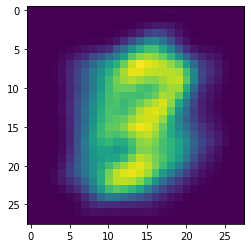

In [173]:
# plt.imshow(np.reshape(p_t[29][0], [28, 28])) 
plt.imshow(np.reshape(p_t[30][0], [28, 28]))

!. I'm Excited!!! We have a lead, with optimizer Adam, loss:174, lr:0.001.

with Adam VAE(), latent_dim = 4, loss = 120(36 epoch), lr=0.003, batch_size=5, trian_len=46, epochs=50, we can see something

In [92]:
optimizer

In [102]:
optimizer._initial_decay = 0.5

In [103]:
optimizer

0.5